# GTSRB classification with CNN - First convolutions

Inspired by the [GTSRB Fidle tutorial](https://fidle.cnrs.fr/w3/)

## 1. Imports

In [101]:
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time as time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from utils import plot_imgs

## 2. Parameters

In [102]:
enhanced_dir = './prepared_data'
dataset_name = 'set-24x24-L'
batch_size   = 64
num_epochs   = 64
rng          = np.random.default_rng()

## 3. Load dataset

In [103]:
def read_dataset(enhanced_dir, dataset_name):
	# Read dataset
	filename = f'{enhanced_dir}/{dataset_name}.h5'
	with h5py.File(filename,'r') as f:
		x_train = f['x_train'][:]
		y_train = f['y_train'][:]
		x_test  = f['x_test'][:]
		y_test  = f['y_test'][:]
		x_meta  = f['x_meta'][:]
		y_meta  = f['y_meta'][:]

	return x_train, y_train, x_test, y_test, x_meta, y_meta

x_train, y_train, x_test, y_test, x_meta, y_meta = read_dataset(enhanced_dir, dataset_name)
train_loader = DataLoader(list(zip(x_train, y_train)), batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(list(zip(x_test, y_test)), batch_size=batch_size, shuffle=False)

In [104]:
def plot_imgs(images, labels, num_imgs, cols): # TODO: use this fonction with utils.py
	rows = (num_imgs + cols - 1) // cols

	fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
	fig.subplots_adjust(hspace=0.5, wspace=0.5)

	# Show the images
	for i in range(num_imgs):
		ax = axes[i // cols, i % cols]
		ax.imshow(images[i], cmap='gray' if images[i].shape[2] == 1 else None)
		ax.set_xlabel(labels[i])
		ax.set_xticks([])
		ax.set_yticks([])

	# Fill the empty plots with white images
	for j in range(len(y_meta), rows * cols):
		ax = axes[j // cols, j % cols]
		ax.axis('off')

	plt.show()

x_train :  (7841, 24, 24, 1)
y_train :  (7841,)
x_test  :  (12630, 24, 24, 1)
y_test  :  (12630,)


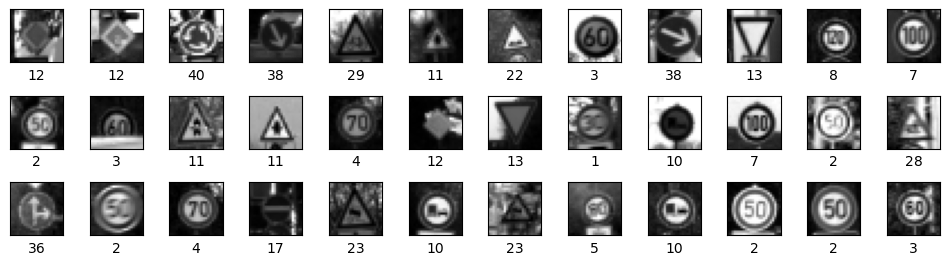

In [105]:
# Verify the dataset
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)
plot_imgs(x_train, y_train, 36, 12)

## 4. Create the model

In [106]:
# Basic model
class Model1(nn.Module):
	def __init__(self, lx, ly, lz):
		super(Model1, self).__init__()

		self.conv1 = nn.Conv2d(lz, 96, kernel_size=3)
		self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
		self.drop1 = nn.Dropout(0.2)

		self.conv2 = nn.Conv2d(96, 192, kernel_size=3)
		self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
		self.drop2 = nn.Dropout(0.2)

		self.flatten = nn.Flatten()
		c1 = (lx - 3 + 0) / 1 + 1 # (lx - k + 2p) / s + 1
		p1 = (c1 - 2) // 2 + 1     # (c1 - k) / s + 1
		c2 = (p1 - 3 + 0) / 1 + 1 # (p1 - k + 2p) / s + 1
		p2 = (c2 - 2) // 2 + 1     # (c2 - k) / s + 1
		out = 192 * p2 * p2
		print(f'c1={c1}, p1={p1}, c2={c2}, p2={p2}, out={out}')
		self.fc1 = nn.Linear(int(out), 1024)
		self.drop3 = nn.Dropout(0.5)

		self.fc2 = nn.Linear(1024, 43)

	def forward(self, x):
		x = F.relu(self.conv1(x))
		x = self.pool1(x)
		x = self.drop1(x)

		x = F.relu(self.conv2(x))
		x = self.pool2(x)
		x = self.drop2(x)

		x = self.flatten(x)
		x = F.relu(self.fc1(x))
		x = self.drop3(x)

		x = F.softmax(self.fc2(x), dim=1)

		return x
	
# Sophisticated model
class Model2(nn.Module):
	def __init__(self, lx, ly, lz):
		super(Model2, self).__init__()

		self.conv1 = nn.Conv2d(lz, 64, kernel_size=3, padding='same')
		self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
		self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
		self.drop1 = nn.Dropout(0.2)

		self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
		self.conv4 = nn.Conv2d(128, 128, kernel_size=3)
		self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
		self.drop2 = nn.Dropout(0.2)

		self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding='same')
		self.conv6 = nn.Conv2d(256, 256, kernel_size=3)
		self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
		self.drop3 = nn.Dropout(0.2)

		self.flatten = nn.Flatten()
		self.fc1 = nn.Linear(256 * ((lx // 8) - 1) * ((ly // 8) - 1), 512)
		self.drop4 = nn.Dropout(0.5)

		self.fc2 = nn.Linear(512, 43)

	def forward(self, x):
		x = F.relu(self.conv1(x))
		x = F.relu(self.conv2(x))
		x = self.pool1(x)
		x = self.drop1(x)

		x = F.relu(self.conv3(x))
		x = F.relu(self.conv4(x))
		x = self.pool2(x)
		x = self.drop2(x)

		x = F.relu(self.conv5(x))
		x = F.relu(self.conv6(x))
		x = self.pool3(x)
		x = self.drop3(x)

		x = self.flatten(x)
		x = F.relu(self.fc1(x))
		x = self.drop4(x)

		x = F.softmax(self.fc2(x), dim=1)

# Sophisticated model but smaller and faster
class Model3(nn.Module):
	def __init__(self, lx, ly, lz):
		super(Model3, self).__init__()

		self.conv1 = nn.Conv2d(lz, 32, kernel_size=3)
		self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
		self.drop1 = nn.Dropout(0.5)

		self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
		self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
		self.drop2 = nn.Dropout(0.5)

		self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
		self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
		self.drop3 = nn.Dropout(0.5)

		self.flatten = nn.Flatten()
		self.fc1 = nn.Linear(128 * ((lx // 8) - 1) * ((ly // 8) - 1), 1024)
		self.drop3 = nn.Dropout(0.5)

		self.fc2 = nn.Linear(1024, 43)

	def forward(self, x):
		x = F.relu(self.conv1(x))
		x = self.pool1(x)
		x = self.drop1(x)

		x = F.relu(self.conv2(x))
		x = self.pool2(x)
		x = self.drop2(x)

		x = F.relu(self.conv3(x))
		x = self.pool3(x)
		x = self.drop3(x)

		x = self.flatten(x)
		x = F.relu(self.fc1(x))
		x = self.drop3(x)

		x = F.softmax(self.fc2(x), dim=1)

## 5. Train the model

In [107]:
# Get data shape
n, lx, ly, lz = x_train.shape
print('Images of the dataset have this shape:', (lx, ly, lz))

trainLoader = DataLoader(list(zip(x_train, y_train)), batch_size=batch_size, shuffle=True)

# Create model
model = Model1(lx, ly, lz)
display(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print('Model moved to', device)

Images of the dataset have this shape: (24, 24, 1)
c1=22.0, p1=11.0, c2=9.0, p2=4.0, out=3072.0


Model1(
  (conv1): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (drop3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=43, bias=True)
)

Model moved to cuda


In [108]:
# Create a directory to save the model
os.makedirs('models', mode=0o750, exist_ok=True)
save_path = f'models/first-convolutions-{dataset_name}.pth'

best_accuracy = 0
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):

	# Train the model
	model.train()
	train_loss = 0
	train_accuracy = 0
	
	for i, data in enumerate(train_loader, 0):
		images, labels = data
		images = images.permute(0, 3, 1, 2) # Change the shape of the images
		images, labels = images.to(device), labels.to(device) # Move to device
		optimizer.zero_grad()
		outputs = model(images)
		loss = criterion(outputs, labels)
		loss.backward()
		optimizer.step()

		train_loss += loss.item()
		train_accuracy += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

	train_losses.append(train_loss / len(train_loader))
	train_accuracies.append(train_accuracy / len(train_loader.dataset))

	# Evaluate the model
	model.eval()
	test_loss = 0
	test_accuracy = 0

	with torch.no_grad():
		for i, data in enumerate(test_loader, 0):
			images, labels = data
			images, labels = images.to(device), labels.to(device) # Move to device
			images = images.permute(0, 3, 1, 2) # Change the shape of the images
			outputs = model(images)
			loss = criterion(outputs, labels)
			test_loss += loss.item()
			test_accuracy += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

	test_losses.append(test_loss / len(test_loader))
	test_accuracies.append(test_accuracy / len(test_loader.dataset))
	if (epoch + 1) % 4 == 0:
		print(f'Epoch {epoch + 1}/{num_epochs}:\tLoss: {test_losses[-1]:.4f},\tAccuracy: {test_accuracies[-1]:.4f}')

	# Save the model if the accuracy is better
	if test_accuracies[-1] > best_accuracy:
		best_accuracy = test_accuracies[-1]
		torch.save(model.state_dict(), save_path)

Epoch 4/64:	Loss: 3.7458,	Accuracy: 0.0546
Epoch 8/64:	Loss: 3.6199,	Accuracy: 0.1791
Epoch 12/64:	Loss: 3.4624,	Accuracy: 0.3429
Epoch 16/64:	Loss: 3.3611,	Accuracy: 0.4473
Epoch 20/64:	Loss: 3.3030,	Accuracy: 0.5020
Epoch 24/64:	Loss: 3.2813,	Accuracy: 0.5234
Epoch 28/64:	Loss: 3.2810,	Accuracy: 0.5223
Epoch 32/64:	Loss: 3.2723,	Accuracy: 0.5301
Epoch 36/64:	Loss: 3.2705,	Accuracy: 0.5312
Epoch 40/64:	Loss: 3.2677,	Accuracy: 0.5339
Epoch 44/64:	Loss: 3.2632,	Accuracy: 0.5396
Epoch 48/64:	Loss: 3.2570,	Accuracy: 0.5440
Epoch 52/64:	Loss: 3.2558,	Accuracy: 0.5454
Epoch 56/64:	Loss: 3.2572,	Accuracy: 0.5444
Epoch 60/64:	Loss: 3.2269,	Accuracy: 0.5749
Epoch 64/64:	Loss: 3.2231,	Accuracy: 0.5789


## 6. Evaluate

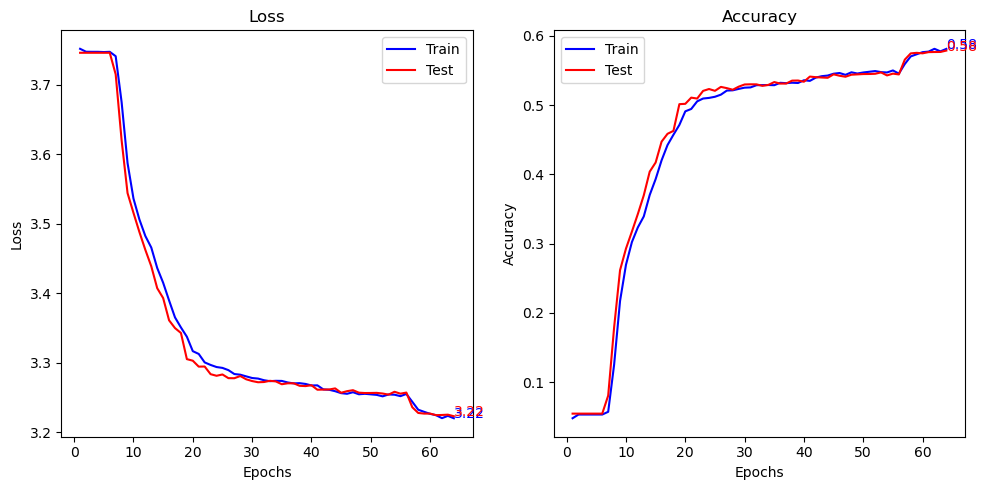

In [109]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 5))

# Plot the loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Train')
plt.plot(epochs, test_losses, 'r', label='Test')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.annotate(
	f'{train_losses[-1]:.2f}',
	xy         = (epochs[-1], train_losses[-1]),
	xytext     = (epochs[-1], train_losses[-1]),
	color      = 'b',
	arrowprops = None
)
plt.annotate(
	f'{test_losses[-1]:.2f}',
	xy         = (epochs[-1], test_losses[-1]),
	xytext     = (epochs[-1], test_losses[-1]),
	color      = 'r',
	arrowprops = None
)

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Train')
plt.plot(epochs, test_accuracies, 'r', label='Test')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.annotate(
	f'{train_accuracies[-1]:.2f}',
	xy         = (epochs[-1], train_accuracies[-1]),
	xytext     = (epochs[-1], train_accuracies[-1]),
	color      = 'b',
	arrowprops = None
)
plt.annotate(
	f'{test_accuracies[-1]:.2f}',
	xy         = (epochs[-1], test_accuracies[-1]),
	xytext     = (epochs[-1], test_accuracies[-1]),
	color      = 'r',
	arrowprops = None
)

plt.tight_layout()
plt.show()

## 7. Restore the model

In [113]:
model_path = f'models/first-convolutions-{dataset_name}.pth'
model = Model1(lx, ly, lz)
model.load_state_dict(torch.load(model_path, weights_only=True))
display(model)

c1=22.0, p1=11.0, c2=9.0, p2=4.0, out=3072.0


Model1(
  (conv1): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (drop3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=43, bias=True)
)

## 8. Make predictions

In [119]:
# Make predictions
all_images = []
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
	for images, labels in test_loader:
		images = images.permute(0, 3, 1, 2) # Change the shape of the images
		outputs = model(images)
		y_sigmoid = torch.nn.functional.softmax(outputs, dim=1)
		y_pred = torch.argmax(y_sigmoid, dim=1)
		
		all_images.append(images.cpu())
		all_labels.append(labels.cpu())
		all_preds.append(y_pred.cpu())

all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)
all_preds = torch.cat(all_preds, dim=0)

print(f'Loss     : {criterion(outputs, labels).item():.4f}')
print(f'Accuracy : {torch.sum(all_labels == all_preds).item() / len(all_labels):.4f}')

Loss     : 3.1636
Accuracy : 0.5789
